In [22]:
rm(list = ls())

library(dplyr)
library(glmmTMB)
library(ggplot2)
library(performance)
library(DHARMa)

Reading the data, and understanding its structure:

In [23]:
setwd("/Users/lindawinnicki/Documents/lu_bios15/git_bios15")
df_eucalypt <- read.csv("./data/exam2023_data-2.csv")
df_eucalypt$Season <- as.factor(df_eucalypt$Season)
df_eucalypt$Property <- as.factor(df_eucalypt$Property)
df_eucalypt$Landscape.position <- as.factor(df_eucalypt$Landscape.position)
str(df_eucalypt)

'data.frame':	351 obs. of  38 variables:
 $ SurveyID                      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Date                          : chr  "24/07/2006" "24/07/2006" "24/07/2006" "24/07/2006" ...
 $ Season                        : Factor w/ 3 levels "Autumn 2007",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ Property                      : Factor w/ 18 levels "Barlow","Blaber",..: 1 1 1 1 1 1 2 2 2 2 ...
 $ Quadrat.no                    : int  1 2 3 4 5 6 1 2 3 4 ...
 $ Easting                       : int  310042 310087 310240 309998 309958 310137 386643 386736 386732 386633 ...
 $ Northing                      : int  5934571 5934567 5934699 5934968 5934752 5934765 5936462 5936384 5936315 5936324 ...
 $ Aspect                        : chr  "nne" "ne" "se" "0" ...
 $ Landscape.position            : Factor w/ 4 levels "crest","flat",..: 3 3 3 2 2 2 3 3 3 3 ...
 $ ExoticAnnualGrass_cover       : num  5.7 6.7 2.3 5 5.7 4.3 1.7 3 1.7 1.7 ...
 $ ExoticAnnualHerb_cover        : num  0.3 3.6 0 1.3 4.7 

Now, the data is loaded, and the hypothesis is whether there is a higher effect of herb covers on Eucalyptus abundance compared to non-plant cover types. To begin the testing, the seedlings are all captured into one column (abundance), as the growth of individuals can't be tested due to quadrants within property being different each survey.

In [24]:
df_eucalypt$seedlings_tot <- df_eucalypt$euc_sdlgs0_50cm + 
  df_eucalypt$euc_sdlgs50cm.2m + 
  df_eucalypt$euc_sdlgs.2m

Now we extract some chosen predictors, and random effects, and prepare the data for analysis.

In [35]:
model_cols <- c("seedlings_tot",
  "Season",
  "Property",
  "BareGround_cover",
  "Litter_cover",
  "MossLichen_cover",
  "Rock_cover")
df_model <- df_eucalypt[, model_cols]

Now, some rows in the data contains rows with NA values, and because there are so few of them, they are removed from the dataset.

In [37]:
na_rows <- which(!complete.cases(df_model)) # which rows are NOT complete?
cat("row(s)", na_rows, "will be removed, in total:", length(na_rows), "rows", "\n")
df_model_clean <- na.omit(df_model)

row(s) 75 will be removed, in total: 1 rows 


Now it's time to choose a fitting model. From the information about the data, there are three surveys (Season), multiple repeating properties (Property). The quadrants are chosen differently each survey within a property, making them not suitable as random effects. The response variable is abundance of seedlings, which is count data, so a Poisson/Quasi/NB distribution is suitable for the model. To figure out which one to choose, we begin by looking at how the variance and mean of the abundance data compares.

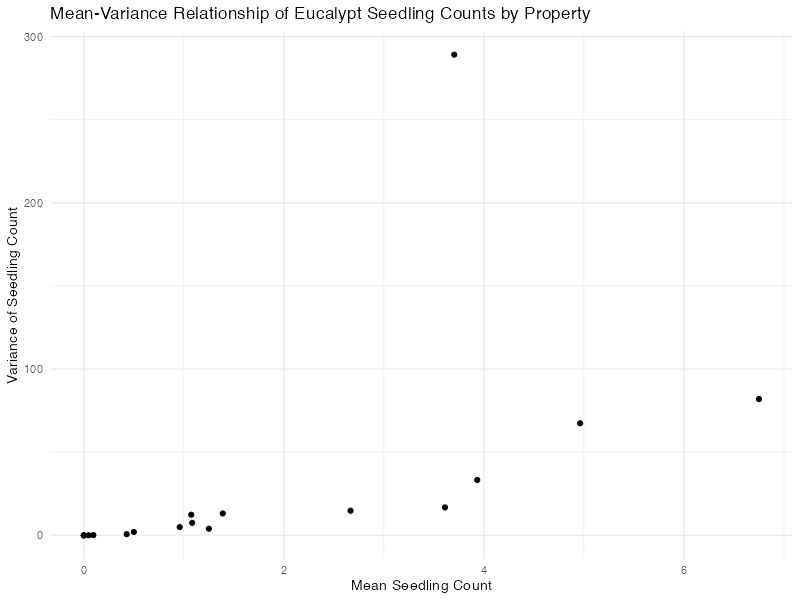

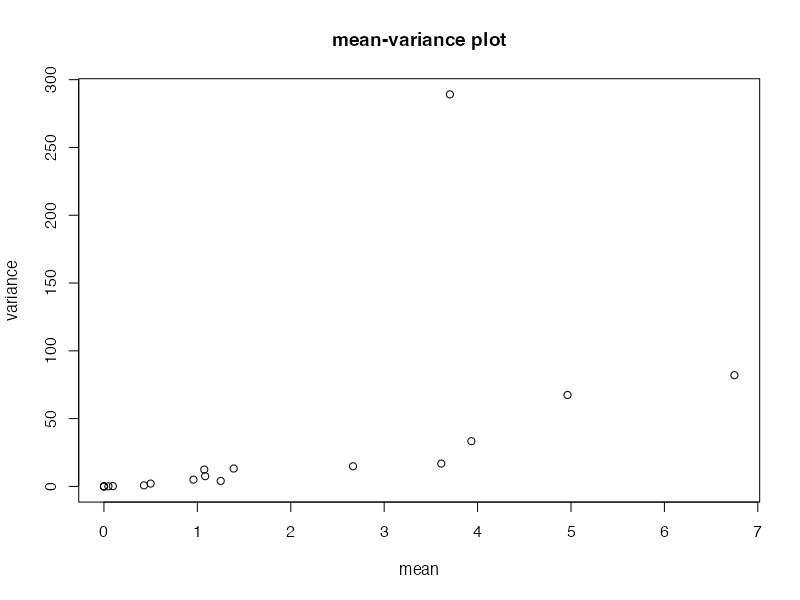

In [38]:
mean_var <- df_model_clean %>%
  group_by(Property) %>%              # or Season, or any grouping, or none
  summarise(
    mean_count = mean(seedlings_tot),
    var_count  = var(seedlings_tot)
  )

ggplot(mean_var, aes(x = mean_count, y = var_count)) +
  geom_point() +
  labs(
    title = "Mean-Variance Relationship of Eucalypt Seedling Counts by Property",
    x = "Mean Seedling Count",
    y = "Variance of Seedling Count"
  ) +
  theme_minimal()

plot(mean_var$mean_count,
    mean_var$var_count,
    #  type = "l",
     xlab = "mean",
     ylab = "variance",
     main = "mean-variance plot")

One outlier makes the variance seem to grow exponentially compared to the mean, but even without it, the variance is still higher than the mean itself, indicating some kind of overdispersion. Without the outlier, it looks like its growing lineraly. Therefore, a Negative Binomial distribution is chosen as the model, and whether to choose nbinom1 or nbinom2 is determined by fitting both and comparing AIC values.

In [39]:
m <- glmmTMB(seedlings_tot ~ 
  BareGround_cover + 
  Litter_cover + 
  MossLichen_cover + 
  Rock_cover + 
  (1 | Property) + 
  (1 | Season),
df_model_clean, "nbinom2")
summary(m)

 Family: nbinom2  ( log )
Formula:          seedlings_tot ~ BareGround_cover + Litter_cover + MossLichen_cover +  
    Rock_cover + (1 | Property) + (1 | Season)
Data: df_model_clean

      AIC       BIC    logLik -2*log(L)  df.resid 
    902.6     933.5    -443.3     886.6       342 

Random effects:

Conditional model:
 Groups   Name        Variance  Std.Dev. 
 Property (Intercept) 2.932e+00 1.712e+00
 Season   (Intercept) 3.173e-09 5.633e-05
Number of obs: 350, groups:  Property, 18; Season, 3

Dispersion parameter for nbinom2 family (): 0.163 

Conditional model:
                   Estimate Std. Error z value Pr(>|z|)  
(Intercept)      -0.8650626  0.6415929  -1.348   0.1776  
BareGround_cover  0.0284641  0.0126208   2.255   0.0241 *
Litter_cover     -0.0004572  0.0077131  -0.059   0.9527  
MossLichen_cover  0.0075779  0.0119135   0.636   0.5247  
Rock_cover        0.0154623  0.0203179   0.761   0.4466  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [40]:
m <- glmmTMB(seedlings_tot ~ 
  BareGround_cover + 
  Litter_cover + 
  MossLichen_cover + 
  Rock_cover + 
  (1 | Property) + 
  (1 | Season),
df_model_clean, "nbinom1")
summary(m)

 Family: nbinom1  ( log )
Formula:          seedlings_tot ~ BareGround_cover + Litter_cover + MossLichen_cover +  
    Rock_cover + (1 | Property) + (1 | Season)
Data: df_model_clean

      AIC       BIC    logLik -2*log(L)  df.resid 
    869.1     899.9    -426.5     853.1       342 

Random effects:

Conditional model:
 Groups   Name        Variance  Std.Dev. 
 Property (Intercept) 1.235e+00 1.1113207
 Season   (Intercept) 1.815e-08 0.0001347
Number of obs: 350, groups:  Property, 18; Season, 3

Dispersion parameter for nbinom1 family (): 13.9 

Conditional model:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.569416   0.480293  -1.186 0.235796    
BareGround_cover  0.009009   0.007490   1.203 0.229086    
Litter_cover      0.003378   0.005236   0.645 0.518812    
MossLichen_cover  0.022561   0.006727   3.354 0.000797 ***
Rock_cover        0.009025   0.011787   0.766 0.443882    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [41]:
check_collinearity(m)

# Check for Multicollinearity

Low Correlation

             Term  VIF   VIF 95% CI adj. VIF Tolerance Tolerance 95% CI
 BareGround_cover 1.31 [1.18, 1.53]     1.15      0.76     [0.65, 0.85]
     Litter_cover 1.43 [1.28, 1.67]     1.20      0.70     [0.60, 0.78]
 MossLichen_cover 1.35 [1.21, 1.58]     1.16      0.74     [0.63, 0.82]
       Rock_cover 1.07 [1.01, 1.38]     1.03      0.94     [0.72, 0.99]

Dispersion statistics are also calculated for the models to ensure that the chosen model is appropriate.

In [42]:
deviance(m) / df.residual(m) 

[1] 0.4928805

In [47]:
# making a data set ####
BareGround_cover_mean <- mean(df_model_clean$BareGround_cover)
Litter_cover_mean <- mean(df_model_clean$Litter_cover)
Rock_cover_mean <- mean(df_model_clean$Rock_cover)
MossLichen_cover_seq <- seq(min(df_model_clean$MossLichen_cover), max(df_model_clean$MossLichen_cover), length = 350)

df_lichen_plot <- data.frame(BareGround_cover = BareGround_cover_mean,
  Litter_cover = Litter_cover_mean,
  Rock_cover = Rock_cover_mean,
  MossLichen_cover = MossLichen_cover_seq)

In [51]:
df_lichen_plot$pred <- predict(
  m,
  newdata = df_lichen_plot,
  type = "response",
  re.form = NA
)

pred_lichen_se <- predict(
  m, 
  newdata = df_lichen_plot, 
  type = "link", 
  se.fit = TRUE, 
  re.form = NA
)

highest <- exp(pred_lichen_se$fit + (1.96 * pred_lichen_se$se.fit))
lowest <- exp(pred_lichen_se$fit - (1.96 * pred_lichen_se$se.fit))


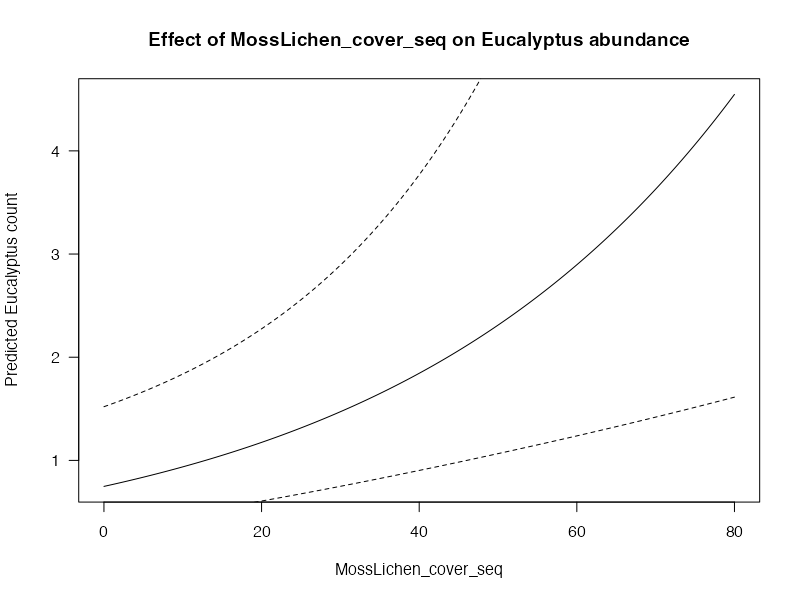

In [54]:
plot(MossLichen_cover_seq, df_lichen_plot$pred, 
  type="l",
  las = 1, 
  # col="skyblue",
  # ylim = c(0,400),
  xlab="MossLichen_cover_seq",
  ylab="Predicted Eucalyptus count",   
  main="Effect of MossLichen_cover_seq on Eucalyptus abundance",)
lines(MossLichen_cover_seq, highest, 
  # col="skyblue", 
  lty=2)
lines(MossLichen_cover_seq, lowest, 
  # col="skyblue", 
  lty=2)